In [1]:
import numpy as np
import pesfit as pf
from silx.io.dictdump import dicttoh5, h5todict
import matplotlib.pyplot as plt
import lmfit.models as lmm
from tqdm import notebook as nb
import pandas as pd

## 3.1 Fitting of a patch of photoemission spectra (patch fitting)
The following code demonstrate a few levels of lineshape fitting automation

In [3]:
# Load energy initialization
# krec = h5todict(r'E:\Momentoscope\WSe2\krec_lda_kpoint.h5')['recon']
krec = h5todict(r'..\data\WSe2\recon\kpoint\krec_lda_kpoint.h5')['recon']
krec.shape

(14, 30, 30)

In [4]:
# Load photoemission data
fdata = h5todict(r'..\data\WSe2\pes\kpoint\kpoint_symmetrized.h5')
Es = fdata['E'][20:100] # Energy values
eofs = 0.015 # Energy offset
sfts = np.arange(-0.08, 0.09, 0.01) # Choices of random shifts

### 3.1.1 Serial patch fitting
#### (a) Fitting using explicit coded steps

In [2]:
bpatch = np.zeros((2, 30, 30))
spatch = np.zeros((2, 30, 30))
gpatch = np.zeros((2, 30, 30))

# Initialize the model
mdl = pf.fitter.model_generator(peaks={'Voigt':2}, background='None')
pars = mdl.make_params()

vardict = [{'lp1_':{'amplitude':dict(value=0.2, min=0, max=2, vary=True),
                  'sigma':dict(value=0.1, min=0.05, max=2, vary=False),
                  'gamma':dict(value=0.02, min=0, max=2, vary=True)}},
           
           {'lp2_':{'amplitude':dict(value=0.2, min=0, max=2, vary=True),
                   'sigma':dict(value=0.1, min=0.05, max=2, vary=False),
                   'gamma':dict(value=0.02, min=0, max=2, vary=True)}}]

pf.fitter.varsetter(pars, vardict, ret=False)

In [5]:
for r in nb.tqdm(range(30)):
#     print(r)
    for c in range(30):

        row_id, col_id = r, c

        # Update the band position estimates (corresponding to the centers of the lineshape components)
        centerdict = [{'lp1_':{'center':dict(value=krec[0,row_id,col_id]+eofs, vary=True)}},
                      {'lp2_':{'center':dict(value=krec[1,row_id,col_id]+eofs, vary=True)}}]

        pf.fitter.varsetter(pars, centerdict, ret=False)
        y = fdata['V'][row_id, col_id, 20:100]
        fit_result = mdl.fit(y/y.max(), pars, x=Es)

        # Add random shift to the initialization to produce better fits
        out = pf.fitter.random_varshift(fit_result, model=mdl, params=pars, yvals=y, xvals=Es, shifts=sfts)
        comps = out.eval_components(x=Es)

        bpatch[0,r,c] = out.params['lp1_center'].value
        bpatch[1,r,c] = out.params['lp2_center'].value

        spatch[0,r,c] = out.params['lp1_sigma'].value
        spatch[1,r,c] = out.params['lp2_sigma'].value

        gpatch[0,r,c] = out.params['lp1_gamma'].value
        gpatch[1,r,c] = out.params['lp2_gamma'].value

Text(0.5, 0.98, 'Band #2 dispersion surface around K')

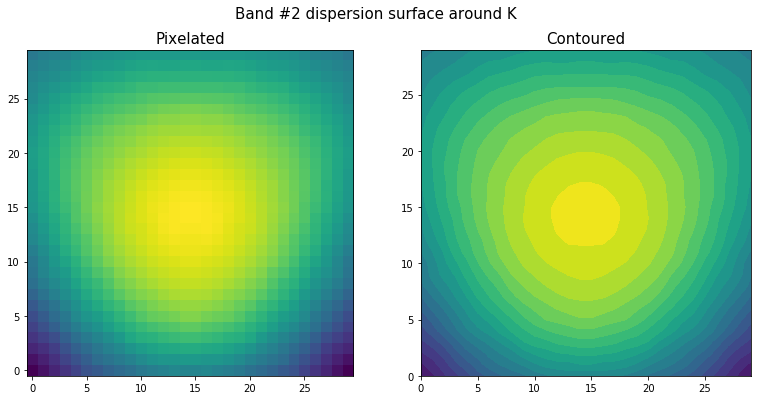

In [6]:
band_ind = 2
f, ax = plt.subplots(1, 2, figsize=(13, 6))
ax[0].imshow(bpatch[band_ind-1,...], origin='lower')
ax[1].contourf(bpatch[band_ind-1,...], 20)
ax[0].set_title('Pixelated', fontsize=15)
ax[1].set_title('Contoured', fontsize=15)
plt.suptitle('Band #{} dispersion surface around K'.format(band_ind), fontsize=15)

#### (b) Fitting using ``pesfit.fitter.pointwise_fitting()`` method

In [7]:
eofs = 0.015 # Energy offset
mdl = pf.fitter.model_generator(peaks={'Voigt':2}, background='None')
pars = mdl.make_params()

vardict = [{'lp1_':{'amplitude':dict(value=0.2, min=0, max=2, vary=True),
                  'sigma':dict(value=0.1, min=0.05, max=2, vary=False),
                  'gamma':dict(value=0.02, min=0, max=2, vary=True)}},
           
           {'lp2_':{'amplitude':dict(value=0.2, min=0, max=2, vary=True),
                   'sigma':dict(value=0.1, min=0.05, max=2, vary=False),
                   'gamma':dict(value=0.02, min=0, max=2, vary=True)}}]
pf.fitter.varsetter(pars, vardict, ret=False)

In [8]:
# DataFrame torage of fitting parameters
df_fit = pd.DataFrame(columns=pars.keys())

erange = slice(20, 100)
Es = fdata['E'][erange] # Energy values
ys = fdata['V'][..., erange] # Patch of photoemission spectra
nspec = np.prod(ys.shape[:-1]) # Number of spectra

# Partially flatten data to 2D for ease of iteration
ys2d = pf.utils.partial_flatten(ys, axis=(0, 1))
krec2d = pf.utils.partial_flatten(krec, axis=(1, 2))

for d in nb.tqdm(range(nspec)):
    
    centerdict = [{'lp1_':{'center':dict(value=krec2d[0,d]+eofs, vary=True)}},
                  {'lp2_':{'center':dict(value=krec2d[1,d]+eofs, vary=True)}}]

    pf.fitter.varsetter(pars, centerdict, ret=False)
        
    ydata = ys2d[d, :]
    # Carry out fitting for each spectrum
    out = pf.fitter.pointwise_fitting(Es, ydata, model=mdl, params=pars, jitter_init=False,
                                      shifts=np.arange(-0.08, 0.09, 0.01), verbose=True)
#     pf.fitter.plot_fit_result(out, Es)

    dfout = pf.utils.df_collect(out.params, currdf=df_fit)
    df_fit = dfout

In [9]:
band_ind = 2
band_energy = df_fit['lp'+str(band_ind)+'_center'].values.reshape((30, 30))

Text(0.5, 0.98, 'Band #2 dispersion surface around K')

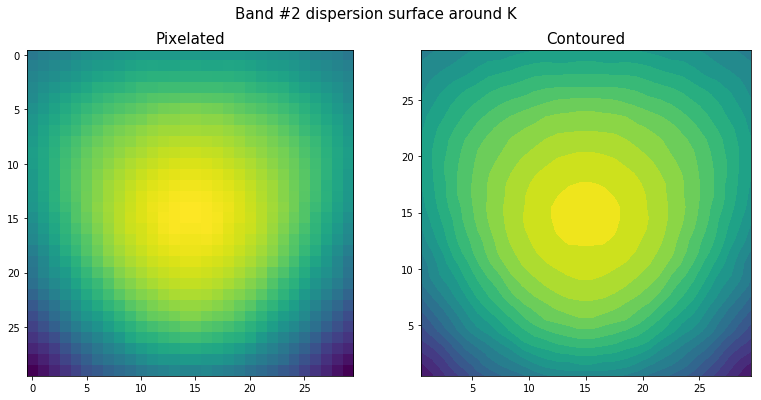

In [10]:
f, ax = plt.subplots(1, 2, figsize=(13, 6))
ax[0].imshow(band_energy)
ax[1].contourf(band_energy, 20, origin='upper')
ax[0].set_title('Pixelated', fontsize=15)
ax[1].set_title('Contoured', fontsize=15)
plt.suptitle('Band #{} dispersion surface around K'.format(band_ind), fontsize=15)

### 3.1.2 Fitting using ``pesfit.fitter.PatchFitter`` class

In [11]:
fdata = h5todict(r'..\data\WSe2\pes\kpoint\kpoint_symmetrized.h5')

kfit = pf.fitter.PatchFitter(xdata=fdata['E'], ydata=fdata['V'])
# kfit.load_spec_data(fdir=r'..\data\WSe2\pes\kpoint\kpoint_symmetrized.h5', parts='V')

vardict = [{'lp1_':{'amplitude':dict(value=0.2, min=0, max=2, vary=1.),
                  'sigma':dict(value=0.1, min=0.05, max=2, vary=False),
                  'gamma':dict(value=0.02, min=0, max=2, vary=True),
                  'center':dict(vary=True)}},
           
           {'lp2_':{'amplitude':dict(value=0.2, min=0, max=2, vary=True),
                   'sigma':dict(value=0.1, min=0.05, max=2, vary=False),
                   'gamma':dict(value=0.02, min=0, max=2, vary=True),
                   'center':dict(vary=True)}}]

kfit.set_inits(inits_dict=vardict, band_inits=krec, drange=slice(20,100))

In [12]:
# Sequentially fit each line spectrum
kfit.sequential_fit(pbar=True, jitter_inits=True, shifts=np.arange(-0.08, 0.09, 0.01), nspec=900)

In [13]:
band_ind = 2
band_energy = kfit.df_fit['lp'+str(band_ind)+'_center'].values.reshape((30, 30))

Text(0.5, 0.98, 'Band #2 dispersion surface around K')

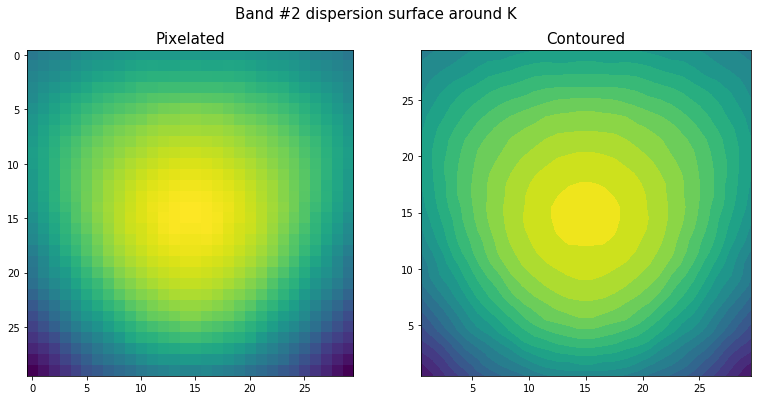

In [14]:
f, ax = plt.subplots(1, 2, figsize=(13, 6))
ax[0].imshow(band_energy)
ax[1].contourf(band_energy, 20, origin='upper')
ax[0].set_title('Pixelated', fontsize=15)
ax[1].set_title('Contoured', fontsize=15)
plt.suptitle('Band #{} dispersion surface around K'.format(band_ind), fontsize=15)